In [1]:
import re       # For regular expressions (e.g., cleaning text)
import os       # For interacting with the operating system
import joblib   # For saving/loading trained models


import numpy as np              # Numerical operations
import pandas as pd             # Data manipulation and analysis
import matplotlib.pyplot as plt # Plotting and visualization
import seaborn as sns           # Statistical data visualization (built on top of matplotlib)


from sklearn.decomposition import PCA  # Principal Component Analysis


from sklearn.ensemble import (               # Ensemble learning models
    GradientBoostingClassifier,
    RandomForestClassifier
)
from sklearn.linear_model import Lasso       # Lasso regression (used for feature selection)
from sklearn.naive_bayes import MultinomialNB # Naive Bayes classifier
from sklearn.neighbors import KNeighborsClassifier # K-Nearest Neighbors classifier
from sklearn.svm import SVC                  # Support Vector Classifier
from xgboost import XGBClassifier            # Extreme Gradient Boosting (XGBoost)


from sklearn.feature_extraction.text import CountVectorizer  # Convert sequences to k-mer features
from sklearn.feature_selection import SelectFromModel        # Feature selection using model importance


from sklearn.preprocessing import (
    LabelEncoder,     # Encode labels as integers
    OneHotEncoder,    # One-hot encode categorical variables
    StandardScaler,   # Scale features to zero mean and unit variance
    label_binarize    # Convert multi-class labels to binary format for ROC
)


from sklearn.metrics import (
    accuracy_score,         # Accuracy
    classification_report,  # Precision, recall, f1-score, support
    confusion_matrix,       # Confusion matrix
    roc_curve,              # ROC curve values
    auc,                    # Area Under Curve for ROC
    precision_score,        # Precision
    recall_score,           # Recall
    f1_score                # F1-score
)


from sklearn.model_selection import (
    train_test_split,       # Split data into training and test sets
    cross_val_score,        # Cross-validation
    GridSearchCV,           # Hyperparameter tuning using grid search
    RandomizedSearchCV      # Hyperparameter tuning using randomized search
)


from scipy.stats import uniform, randint  # Used in randomized hyperparameter search


# 1. Uploading the dataset, removing the numbers after the geo_loc, then splitting it

In [2]:
# Load the dataset
df = pd.read_csv('hvr1_cleaned_sequences.csv')

# Apply regex to remove all digits from the geo_loc column
df['geo_loc'] = df['geo_loc'].apply(lambda x: re.sub(r'\d+', '', x))


In [3]:
#Select Features and Target
X = df['HVR1']  # Only using HVR1 sequences
y = df['geo_loc']  # Ethnicity as the target variable

In [4]:
# Split dataset (80% train, 20% test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode ethnicity labels (target) on training data
y_train_encoded = label_encoder.fit_transform(y_train)

In [6]:
# Check which label is associated with which ethnicity in the original dataset
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the label mapping
print("Label Mapping:")
for label, encoded_label in label_mapping.items():
    print(f"Encoded label {encoded_label} -> Geo location: {label}")


Label Mapping:
Encoded label 0 -> Geo location: burkina
Encoded label 1 -> Geo location: india
Encoded label 2 -> Geo location: japan
Encoded label 3 -> Geo location: kenya
Encoded label 4 -> Geo location: russia
Encoded label 5 -> Geo location: spain


# 2. data preprocessing

## 2.1 using kmers and one hot encoding for preprocessing

In [7]:
def generate_kmer_features(sequences, k=7):
    """ Convert sequences into k-mer frequency features using CountVectorizer. """
    # Check if sequences is a DataFrame or Series
    if isinstance(sequences, pd.DataFrame):
        # If it's a DataFrame, use the first column
        sequences_list = sequences.iloc[:, 0].tolist()
    else:
        # If it's a Series, convert directly to list
        sequences_list = sequences.tolist()

    vectorizer = CountVectorizer(analyzer='char', ngram_range=(k, k))
    kmer_features = vectorizer.fit_transform(sequences_list)
    return kmer_features, vectorizer

def one_hot_encode_sequences(sequences):
    """ Convert nucleotide sequences into one-hot encoded format. """
    # Check if sequences is a DataFrame or Series
    if isinstance(sequences, pd.DataFrame):
        # If it's a DataFrame, use the first column
        sequences_list = sequences.iloc[:, 0].tolist()
    else:
        # If it's a Series, convert directly to list
        sequences_list = sequences.tolist()

    # Create arrays of character lists
    sequence_arrays = [list(seq) for seq in sequences_list]

    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
    onehot_features = encoder.fit_transform(np.array(sequence_arrays))
    return onehot_features, encoder
# K-mer Encoding (only on training data)
print("Generating K-mer features...")
X_train_kmer, kmer_vectorizer = generate_kmer_features(X_train)

# Feature Scaling for K-mer features (only on training data)
scaler_kmer = StandardScaler(with_mean=False)  # Preserve sparsity for sparse matrices
X_train_kmer_scaled = scaler_kmer.fit_transform(X_train_kmer)

# One-Hot Encoding (only on training data)
print("Generating One-Hot Encoded features...")
X_train_onehot, onehot_encoder = one_hot_encode_sequences(X_train)

# # Feature Scaling for One-Hot features (only on training data)
# scaler_onehot = StandardScaler(with_mean=False)
# X_train_onehot_scaled = scaler_onehot.fit_transform(X_train_onehot)

# Evaluate encoding methods with Cross-validation
rf = RandomForestClassifier(random_state=42)

def evaluate_model(X_train, y_train, method_name):
    """ Perform 5-fold cross-validation and return mean accuracy. """
    scores = cross_val_score(rf, X_train, y_train_encoded, cv=5, scoring='accuracy')
    print(f"{method_name} Encoding - CV Scores: {scores}")
    print(f"{method_name} Encoding - Mean CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")
    return scores.mean()

# Evaluate K-mer Encoding with CV
print("\nEvaluating K-mer Encoding...")
kmer_accuracy = evaluate_model(X_train_kmer_scaled, y_train, "K-mer")

# Evaluate One-Hot Encoding with CV
print("\nEvaluating One-Hot Encoding...")
onehot_accuracy = evaluate_model(X_train_onehot, y_train, "One-Hot")

# Select Best Encoding Method Based on Cross-Validation Results
best_method = "K-mer" if kmer_accuracy > onehot_accuracy else "One-Hot"
print(f"\nBest encoding method: {best_method}")
print(f"K-mer CV Accuracy: {kmer_accuracy:.4f}")
print(f"One-Hot CV Accuracy: {onehot_accuracy:.4f}")

Generating K-mer features...
Generating One-Hot Encoded features...

Evaluating K-mer Encoding...
K-mer Encoding - CV Scores: [0.9375     0.875      0.95833333 0.89583333 0.9375    ]
K-mer Encoding - Mean CV Accuracy: 0.9208 ± 0.0306

Evaluating One-Hot Encoding...
One-Hot Encoding - CV Scores: [0.9375     0.85416667 0.9375     0.875      0.91666667]
One-Hot Encoding - Mean CV Accuracy: 0.9042 ± 0.0339

Best encoding method: K-mer
K-mer CV Accuracy: 0.9208
One-Hot CV Accuracy: 0.9042


## 2.2 using pca, rf feature selection and original dataset for feature selection

In [8]:
# Convert sparse matrix to dense
X_train_kmer_scaled_dense = X_train_kmer_scaled.toarray()

# 1. PCA Component Selection based on explained variance
def select_pca_components(X, variance_thresholds=[0.8, 0.85, 0.9, 0.95, 0.99]):
    """Select PCA components based on explained variance thresholds."""
    # Fit PCA with maximum possible components
    pca_full = PCA()
    pca_full.fit(X)

    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

    # Find number of components for each threshold
    selected_components = []
    for threshold in variance_thresholds:
        n_components = np.argmax(cumulative_variance >= threshold) + 1
        selected_components.append(n_components)

    print("\nPCA Component Selection:")
    print("Variance Threshold | Number of Components")
    print("-" * 40)
    for thresh, n_comp in zip(variance_thresholds, selected_components):
        print(f"{thresh*100:^16.1f}% | {n_comp:^18d}")

    # Perform PCA for each selected number of components
    results = []
    for i, n in enumerate(selected_components):
        thresh = variance_thresholds[i]  # Get corresponding threshold
        pca = PCA(n_components=n)
        X_pca = pca.fit_transform(X)
        results.append({
            'n_components': n,
            'variance_threshold': thresh,
            'cumulative_variance': np.sum(pca.explained_variance_ratio_),
            'pca_object': pca,
            'transformed_data': X_pca
        })
    return results

# 2. Feature Importance Selection based on importance distribution
def select_features_by_importance(X, rf_model, importance_thresholds=[0.8, 0.85, 0.9, 0.95, 0.99]):
    """Select features based on cumulative importance thresholds."""
    # Get feature importances
    importances = rf_model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    cumulative_importance = np.cumsum(importances[sorted_idx])

    # Find number of features for each threshold
    selected_features = []
    for threshold in importance_thresholds:
        n_features = np.argmax(cumulative_importance >= threshold) + 1
        selected_features.append(n_features)

    print("\nFeature Importance Selection:")
    print("Importance Threshold | Number of Features")
    print("-" * 40)
    for thresh, n_feat in zip(importance_thresholds, selected_features):
        print(f"{thresh*100:^18.1f}% | {n_feat:^17d}")

    # Select features for each threshold
    results = []
    for i, n in enumerate(selected_features):
        thresh = importance_thresholds[i]  # Get corresponding threshold
        selector = SelectFromModel(rf_model, max_features=n, prefit=True)
        X_selected = selector.transform(X)
        results.append({
            'n_features': n,
            'importance_threshold': thresh,
            'transformed_data': X_selected
        })
    return results

# 3. L1 Regularization (Lasso) for Feature Selection
# Set random seed for reproducibility
np.random.seed(42)

# Lasso feature selection with different alpha values
def select_features_lasso(X, y, alpha_values=[0.01, 0.05, 0.1, 0.5, 1.0]):
    results = []

    print("\nLasso (L1) Regularization Feature Selection:")
    print("Alpha | Number of Features Selected")
    print("-" * 40)

    for alpha in alpha_values:
        # Apply Lasso with random_state for determinism
        lasso = Lasso(alpha=alpha, max_iter=10000, tol=1e-4, random_state=42)
        lasso.fit(X, y)

        # Get selected features
        selected_features = np.where(lasso.coef_ != 0)[0]
        n_selected = len(selected_features)

        print(f"{alpha:^5.2f} | {n_selected:^24d}")

        # If no features were selected, skip this alpha
        if n_selected == 0:
            continue

        # Transform data to include only selected features
        X_selected = X[:, selected_features]

        results.append({
            'alpha': alpha,
            'n_features': n_selected,
            'feature_indices': selected_features,
            'transformed_data': X_selected
        })

    return results

# Train Random Forest for feature importance
rf_selector = RandomForestClassifier(random_state=42)
rf_selector.fit(X_train_kmer_scaled_dense, y_train_encoded)

# Get results for both methods
pca_results = select_pca_components(X_train_kmer_scaled_dense)
importance_results = select_features_by_importance(X_train_kmer_scaled_dense, rf_selector)
lasso_results = select_features_lasso(X_train_kmer_scaled_dense, y_train_encoded)

# Evaluate using Random Forest with 5-fold CV
rf_classifier = RandomForestClassifier(random_state=42)

def evaluate_features(X, method_name, n_features):
    scores = cross_val_score(rf_classifier, X, y_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()
    std_score = scores.std()
    print(f"\n{method_name} (n={n_features}):")
    print(f"CV Accuracy: {mean_score:.4f} ± {std_score:.4f}")
    return mean_score, std_score

# Evaluate original data (baseline)
print("\nEvaluating Different Feature Selection Methods:")
baseline_scores = evaluate_features(X_train_kmer_scaled_dense, "Original Data (No Selection)",
                                 X_train_kmer_scaled_dense.shape[1])

# Evaluate PCA
print("\nPCA Results:")
pca_cv_results = []
for result in pca_results:
    scores = evaluate_features(result['transformed_data'], "PCA", result['n_components'])
    pca_cv_results.append(scores)

# Evaluate Feature Importance
print("\nFeature Importance Results:")
importance_cv_results = []
for result in importance_results:
    scores = evaluate_features(result['transformed_data'], "Feature Importance",
                             result['n_features'])
    importance_cv_results.append(scores)

# Evaluate Lasso results
print("\nLasso (L1) Results:")
lasso_cv_results = []
for result in lasso_results:
    scores = evaluate_features(result['transformed_data'], f"Lasso (alpha={result['alpha']})",
                             result['n_features'])
    lasso_cv_results.append(scores)

# Find best performing method
methods = ['Original'] + \
          [f'PCA-{r["n_components"]}' for r in pca_results] + \
          [f'Importance-{r["n_features"]}' for r in importance_results] + \
          [f'Lasso-{r["n_features"]}' for r in lasso_results]

scores = [baseline_scores] + pca_cv_results + importance_cv_results + lasso_cv_results

best_score_idx = np.argmax([s[0] for s in scores])
best_method = methods[best_score_idx]
best_score = scores[best_score_idx]

print("\nBest Performing Method:")
print(f"{best_method} - Accuracy: {best_score[0]:.4f} ± {best_score[1]:.4f}")


PCA Component Selection:
Variance Threshold | Number of Components
----------------------------------------
      80.0      % |         55        
      85.0      % |         64        
      90.0      % |         74        
      95.0      % |         89        
      99.0      % |        112        

Feature Importance Selection:
Importance Threshold | Number of Features
----------------------------------------
       80.0       % |        200       
       85.0       % |        249       
       90.0       % |        322       
       95.0       % |        450       
       99.0       % |        671       

Lasso (L1) Regularization Feature Selection:
Alpha | Number of Features Selected
----------------------------------------
0.01  |           273           
0.05  |           108           
0.10  |            72           
0.50  |            19           
1.00  |            3            

Evaluating Different Feature Selection Methods:

Original Data (No Selection) (n=1328):
CV Ac

In [9]:
# 1. Verify the format of X_test
print(f"Type of X_test: {type(X_test)}")
print(f"First few sequences in X_test: {X_test.head()}")

# Ensure sequences in X_test are strings
X_test = X_test.astype(str)

# 2. Verify the vocabulary of kmer_vectorizer
print(f"Vocabulary size of kmer_vectorizer: {len(kmer_vectorizer.vocabulary_)}")
print(f"First few k-mers in vocabulary: {list(kmer_vectorizer.vocabulary_.items())[:5]}")

# 3. Transform X_test using kmer_vectorizer
X_test_kmer = kmer_vectorizer.transform(X_test.tolist())
print(f"X_test_kmer shape: {X_test_kmer.shape}")

# 4. Feature Scaling for K-mer features (on test data)
X_test_kmer_scaled = scaler_kmer.transform(X_test_kmer)
print(f"X_test_kmer_scaled shape: {X_test_kmer_scaled.shape}")

# 5. Encode ethnicity labels (on test data)
# Later, when encoding test data, use the same encoder
y_test_encoded = label_encoder.transform(y_test)
print(f"y_test_encoded shape: {y_test_encoded.shape}")

Type of X_test: <class 'pandas.core.series.Series'>
First few sequences in X_test: 32     NNNNNNNNNNNNGGGGAAGCAGATTTGGGTACCACCCAAGTATTGA...
272    NNNNTCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGA...
257    NNNNTCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGA...
264    NNNNTCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGA...
56     NNNNNNNTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGA...
Name: HVR1, dtype: object
Vocabulary size of kmer_vectorizer: 1328
First few k-mers in vocabulary: [('nnnntct', 1031), ('nnntctt', 1035), ('nntcttt', 1040), ('ntctttc', 1045), ('tctttca', 1232)]
X_test_kmer shape: (60, 1328)
X_test_kmer_scaled shape: (60, 1328)
y_test_encoded shape: (60,)


# 3. training and testing

## 3.1 Using different models

In [ ]:
!pip install xgboost


In [10]:
# Define the classifiers
classifiers = {
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

# Dictionary to store results
test_results = {}

# Train and test each classifier without cross-validation
# Convert sparse matrices to dense
X_train_kmer_scaled_dense = X_train_kmer_scaled.toarray()
X_test_kmer_scaled_dense = X_test_kmer_scaled.toarray()

# Train and test each classifier
for name, clf in classifiers.items():
    try:
        # Train the classifier on the entire training set
        clf.fit(X_train_kmer_scaled_dense, y_train_encoded)

        # Predict on the training set
        y_train_pred = clf.predict(X_train_kmer_scaled_dense)

        # Predict on the test set
        y_test_pred = clf.predict(X_test_kmer_scaled_dense)

        # Compute training and test accuracy
        train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
        test_accuracy = accuracy_score(y_test_encoded, y_test_pred)

        # Calculate the gap between training and testing accuracy
        accuracy_gap = train_accuracy - test_accuracy

        # Store results in the dictionary
        test_results[name] = {
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'accuracy_gap': accuracy_gap
        }

        # Print results
        print(f"\n{name}: Train Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}, Accuracy Gap = {accuracy_gap:.4f}")

        # Print classification report for the training set
        print(f"\nClassification Report for {name} (Training Set):")
        print(classification_report(y_train_encoded, y_train_pred))

        # Print classification report for the test set
        print(f"\nClassification Report for {name} (Test Set):")
        print(classification_report(y_test_encoded, y_test_pred))

    except Exception as e:
        print(f"Error with {name}: {str(e)}")

# Find the best-performing model based on test set accuracy
best_test_model = max(test_results.items(), key=lambda x: x[1]['test_accuracy'])
print(f"\nBest Performing Model on Test Set: {best_test_model[0]} (Test Accuracy: {best_test_model[1]['test_accuracy']:.4f})")

# Optionally, create a summary DataFrame
performance_df = pd.DataFrame.from_dict(test_results, orient='index')

# Add a column for the accuracy gap
performance_df['accuracy_gap'] = performance_df['train_accuracy'] - performance_df['test_accuracy']

# Display the performance summary
print("\nModel Performance Summary (without Cross-Validation):")
print(performance_df)



KNN: Train Accuracy = 0.8375, Test Accuracy = 0.6667, Accuracy Gap = 0.1708

Classification Report for KNN (Training Set):
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        40
           1       0.91      1.00      0.95        40
           2       0.71      0.75      0.73        40
           3       1.00      0.68      0.81        40
           4       0.86      0.60      0.71        40
           5       0.77      1.00      0.87        40

    accuracy                           0.84       240
   macro avg       0.85      0.84      0.83       240
weighted avg       0.85      0.84      0.83       240


Classification Report for KNN (Test Set):
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.83      1.00      0.91        10
           2       0.36      0.40      0.38        10
           3       1.00      0.40      0.57        10
           4       

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:20:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost: Train Accuracy = 1.0000, Test Accuracy = 0.8667, Accuracy Gap = 0.1333

Classification Report for XGBoost (Training Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        40
           4       1.00      1.00      1.00        40
           5       1.00      1.00      1.00        40

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240


Classification Report for XGBoost (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       0.67      0.60      0.63        10
           3       0.90      0.90      0.90        10
       

# 4. Selecting best performing model

Cross-Validation Accuracy Scores (5 folds): [0.9375     0.875      0.95833333 0.89583333 0.9375    ]
Mean CV Accuracy: 0.9208
Standard Deviation of CV Accuracy: 0.0306
Training Accuracy: 1.0000
Test Accuracy: 0.9167

Classification Report:
              precision    recall  f1-score   support

     burkina       1.00      1.00      1.00        10
       india       1.00      1.00      1.00        10
       japan       0.86      0.60      0.71        10
       kenya       1.00      1.00      1.00        10
      russia       0.69      0.90      0.78        10
       spain       1.00      1.00      1.00        10

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.91        60
weighted avg       0.92      0.92      0.91        60



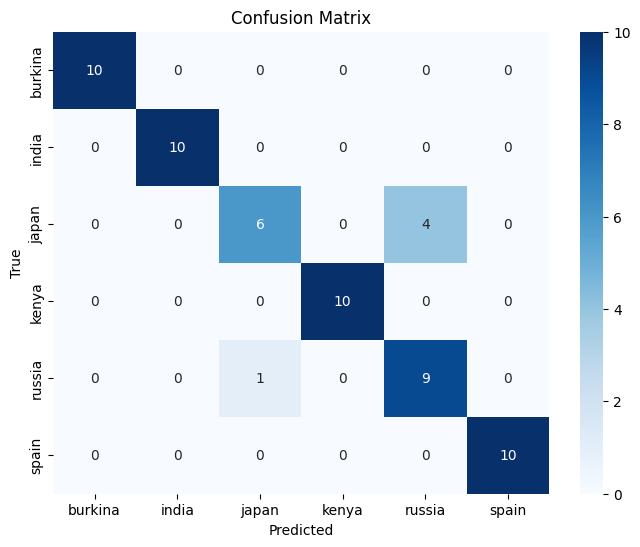

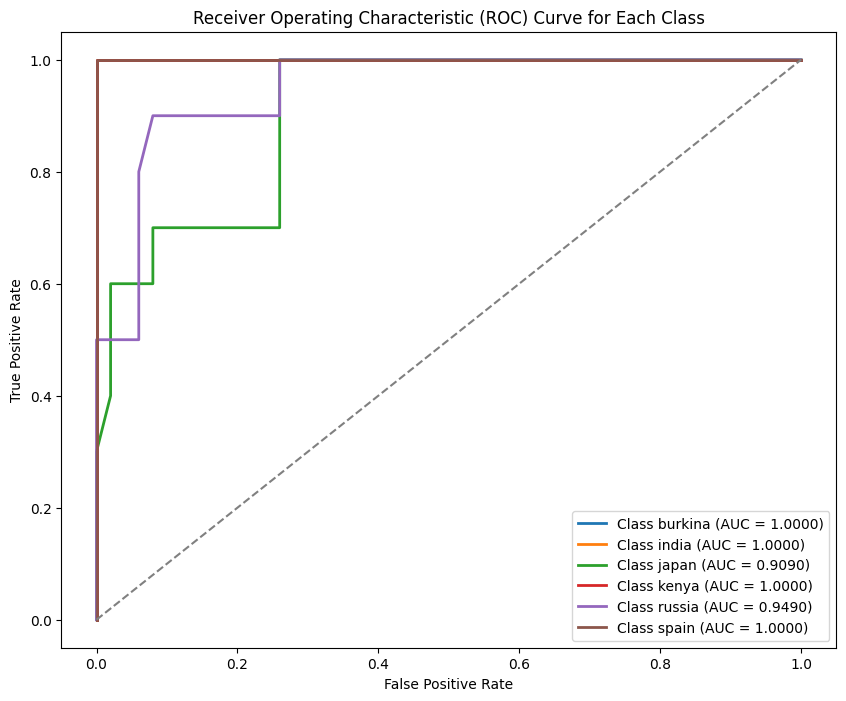

In [11]:
# Load the dataset
df = pd.read_csv('hvr1_cleaned_sequences.csv')

# Apply regex to remove all digits from the geo_loc column
df['geo_loc'] = df['geo_loc'].apply(lambda x: re.sub(r'\d+', '', x))

# Select Features and Target
X = df['HVR1']  # Only using HVR1 sequences
y = df['geo_loc']  # Ethnicity as the target variable

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Encode ethnicity labels (target) on training data
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# K-mer Encoding Function
def generate_kmer_features(sequences, k=7):
    """ Convert sequences into k-mer frequency features using CountVectorizer. """
    if isinstance(sequences, pd.DataFrame):
        sequences_list = sequences.iloc[:, 0].tolist()
    else:
        sequences_list = sequences.tolist()

    vectorizer = CountVectorizer(analyzer='char', ngram_range=(k, k))
    kmer_features = vectorizer.fit_transform(sequences_list)
    return kmer_features, vectorizer

# Feature Scaling Function
scaler_kmer = StandardScaler(with_mean=False)  # Preserve sparsity for sparse matrices

# K-mer Encoding (only on training data)
X_train_kmer, kmer_vectorizer = generate_kmer_features(X_train)
X_test_kmer = kmer_vectorizer.transform(X_test)

# Feature Scaling for K-mer features (on training data)
X_train_kmer_scaled = scaler_kmer.fit_transform(X_train_kmer)
X_test_kmer_scaled = scaler_kmer.transform(X_test_kmer)


# Train a Random Forest Classifier directly on the scaled data
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_kmer_scaled, y_train_encoded)

# Perform 5-fold cross-validation on the training data
cv_scores = cross_val_score(
    rf_model, X_train_kmer_scaled, y_train_encoded, cv=5, scoring='accuracy'
)

# Report cross-validation results
print(f"Cross-Validation Accuracy Scores (5 folds): {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation of CV Accuracy: {cv_scores.std():.4f}")



# Evaluate the model on the training and test sets
train_accuracy = rf_model.score(X_train_kmer_scaled, y_train_encoded)
test_accuracy = rf_model.score(X_test_kmer_scaled, y_test_encoded)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification Report
y_pred = rf_model.predict(X_test_kmer_scaled)
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# Plot Confusion Matrix (in blue color)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve for each class
plt.figure(figsize=(10, 8))

# Predict probabilities for each class
y_pred_proba = rf_model.predict_proba(X_test_kmer_scaled)

# Compute ROC curve and AUC for each class
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_proba[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_name} (AUC = {roc_auc:.4f})')

# Plot the ROC curve
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc='lower right')
plt.show()

In [19]:
#findings the best cv accuracy
# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# List of cross-validation values to test (from 3 to 15)
cv_values = range(3, 11)

# Store results
best_cv = None
best_mean_accuracy = 0
best_std_dev = 0

# Loop through each CV value and calculate cross-validation accuracy
for cv in cv_values:
    cv_accuracies = cross_val_score(rf, X_train_kmer_scaled, y_train_encoded, cv=cv, scoring='accuracy')
    cv_mean_accuracy = np.mean(cv_accuracies)
    cv_std_dev = np.std(cv_accuracies)

    # Print the results for each CV value
    print(f"CV = {cv}: Accuracy = {cv_mean_accuracy:.4f} ± {cv_std_dev:.4f}")

    # Update best CV value if the current one is better
    if cv_mean_accuracy > best_mean_accuracy:
        best_cv = cv
        best_mean_accuracy = cv_mean_accuracy
        best_std_dev = cv_std_dev

# Print the best CV value
print(f"\nBest CV = {best_cv}: Accuracy = {best_mean_accuracy:.4f} ± {best_std_dev:.4f}")

CV = 3: Accuracy = 0.9042 ± 0.0118
CV = 4: Accuracy = 0.9083 ± 0.0186
CV = 5: Accuracy = 0.9208 ± 0.0306
CV = 6: Accuracy = 0.9208 ± 0.0336
CV = 7: Accuracy = 0.9205 ± 0.0307
CV = 8: Accuracy = 0.9167 ± 0.0333
CV = 9: Accuracy = 0.9207 ± 0.0282
CV = 10: Accuracy = 0.9208 ± 0.0573

Best CV = 5: Accuracy = 0.9208 ± 0.0306


# 5. Tunning the selected model

In [ ]:
# Define the distribution for each hyperparameter

param_dist = {
    'n_estimators': randint(50, 500),  # Number of trees in the forest
    'max_features': ['sqrt', 'log2'],  # Number of features to consider at each split
    'max_depth': randint(10, 50),  # Maximum depth of the tree
    'min_samples_split': randint(2, 20),  # Minimum samples required to split a node
    'min_samples_leaf': randint(1, 10),  # Minimum samples required at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize RandomizedSearchCV with 3-fold cross-validation and 100 iterations
randomized_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                       n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

randomized_search.fit(X_train_kmer_scaled, y_train_encoded)

best_params = randomized_search.best_params_
best_model = randomized_search.best_estimator_

print("\nBest Hyperparameters (Randomized Search):")
print(best_params)

# Predict on test set using the best model
y_test_pred_tuned = best_model.predict(X_test_kmer_scaled)

# Evaluate accuracy
tuned_test_accuracy = accuracy_score(y_test_encoded, y_test_pred_tuned)
print(f"\nTest Accuracy after tuning (Randomized Search): {tuned_test_accuracy:.4f}")



Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Hyperparameters (Randomized Search):
{'bootstrap': True, 'max_depth': 47, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 260}

Test Accuracy after tuning (Randomized Search): 0.9000


In [ ]:

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider at each split
    'max_depth': [10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 15, 20],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],  # Minimum samples required at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}


# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Perform Grid Search
grid_search.fit(X_train_kmer_scaled, y_train_encoded)

# Get the best hyperparameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("\nBest Hyperparameters:")
print(best_params)

# Evaluate the tuned model on the test set
y_test_pred_tuned = best_model.predict(X_test_kmer_scaled)

# Compute accuracy after tuning
tuned_test_accuracy = accuracy_score(y_test_encoded, y_test_pred_tuned)
print(f"\nTest Accuracy after tuning: {tuned_test_accuracy:.4f}")


Fitting 5 folds for each of 2160 candidates, totalling 10800 fits

Best Hyperparameters:
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 600}

Test Accuracy after tuning: 0.8833


Training Accuracy: 1.0000
Test Accuracy: 0.9167

Classification Report:
              precision    recall  f1-score   support

     burkina       1.00      1.00      1.00        10
       india       1.00      1.00      1.00        10
       japan       0.86      0.60      0.71        10
       kenya       1.00      1.00      1.00        10
      russia       0.69      0.90      0.78        10
       spain       1.00      1.00      1.00        10

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.91        60
weighted avg       0.92      0.92      0.91        60



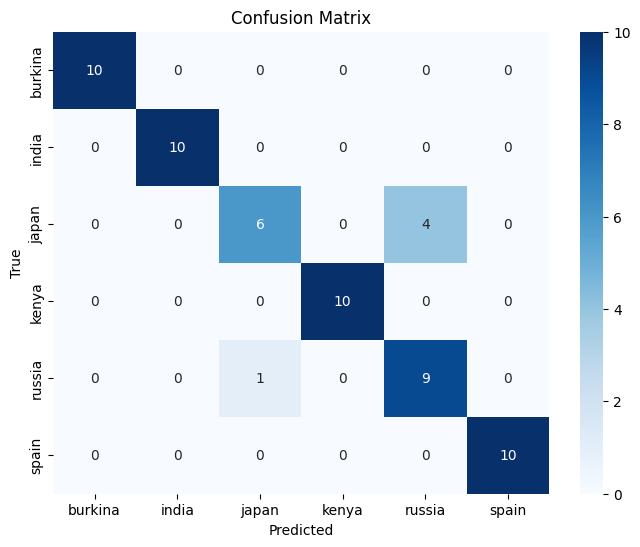

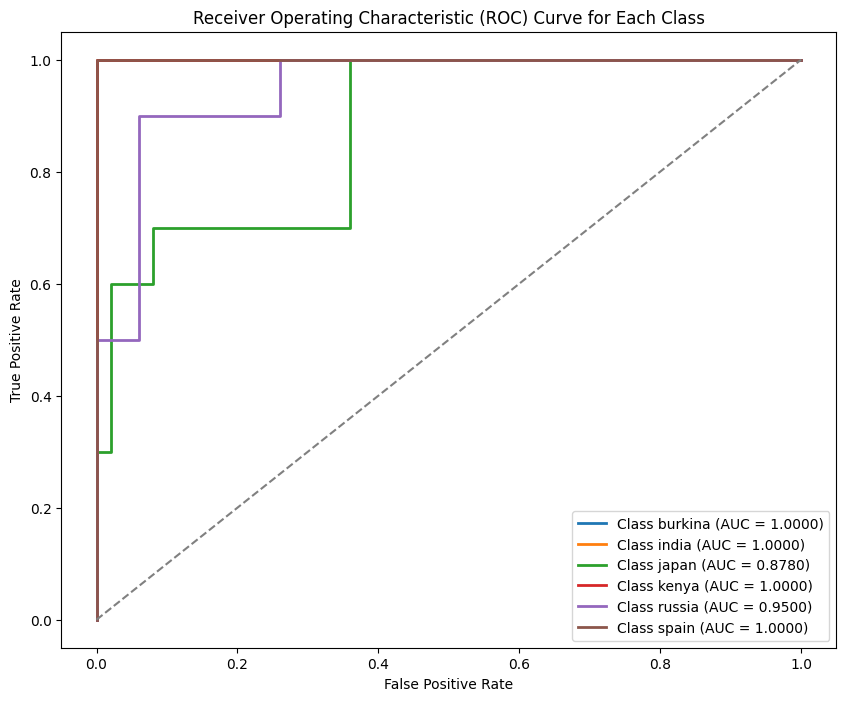

Model and related files have been saved successfully.


In [15]:
# Load the dataset
df = pd.read_csv('hvr1_cleaned_sequences.csv')

# Apply regex to remove all digits from the geo_loc column
df['geo_loc'] = df['geo_loc'].apply(lambda x: re.sub(r'\d+', '', x))

# Select Features and Target
X = df['HVR1']  # Only using HVR1 sequences
y = df['geo_loc']  # Ethnicity as the target variable

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Encode ethnicity labels (target) on training data
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# K-mer Encoding Function
def generate_kmer_features(sequences, k=7):
    """ Convert sequences into k-mer frequency features using CountVectorizer. """
    if isinstance(sequences, pd.DataFrame):
        sequences_list = sequences.iloc[:, 0].tolist()
    else:
        sequences_list = sequences.tolist()

    vectorizer = CountVectorizer(analyzer='char', ngram_range=(k, k))
    kmer_features = vectorizer.fit_transform(sequences_list)
    return kmer_features, vectorizer

# Feature Scaling Function
scaler_kmer = StandardScaler(with_mean=False)  # Preserve sparsity for sparse matrices

# K-mer Encoding (only on training data)
X_train_kmer, kmer_vectorizer = generate_kmer_features(X_train)
X_test_kmer = kmer_vectorizer.transform(X_test)

# Feature Scaling for K-mer features (on training data)
X_train_kmer_scaled = scaler_kmer.fit_transform(X_train_kmer)
X_test_kmer_scaled = scaler_kmer.transform(X_test_kmer)

# Convert sparse matrix to dense for feature selection (removed feature importance part)
X_train_kmer_scaled_dense = X_train_kmer_scaled.toarray()
X_test_kmer_scaled_dense = X_test_kmer_scaled.toarray()

# Train a Random Forest Classifier on the k-mer features
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
)
rf_model.fit(X_train_kmer_scaled_dense, y_train_encoded)

# Evaluate the model on the training and test sets
train_accuracy = rf_model.score(X_train_kmer_scaled_dense, y_train_encoded)
test_accuracy = rf_model.score(X_test_kmer_scaled_dense, y_test_encoded)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification Report
y_pred = rf_model.predict(X_test_kmer_scaled_dense)
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# Plot Confusion Matrix (in blue color)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve for each class
plt.figure(figsize=(10, 8))

# Predict probabilities for each class using X_test_kmer_scaled_dense
y_pred_proba = rf_model.predict_proba(X_test_kmer_scaled_dense)

# Compute ROC curve and AUC for each class
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_proba[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_name} (AUC = {roc_auc:.4f})')

# Plot the ROC curve
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc='lower right')
plt.show()

# Save the trained Random Forest model
joblib.dump(rf_model, 'random_forest_model.joblib')

# Save the K-mer Vectorizer
joblib.dump(kmer_vectorizer, 'kmer_vectorizer.joblib')

# Save the scaler used for feature scaling
joblib.dump(scaler_kmer, 'scaler_kmer.joblib')

# Optionally, save the label encoder as well
joblib.dump(label_encoder, 'label_encoder.joblib')

print("Model and related files have been saved successfully.")


# 6. Saving the model

Test Accuracy: 0.7121

Classification Report:
              precision    recall  f1-score   support

     burkina       1.00      1.00      1.00        11
       india       1.00      0.18      0.31        11
       japan       0.55      0.55      0.55        11
       kenya       0.65      1.00      0.79        11
      russia       0.43      0.55      0.48        11
       spain       1.00      1.00      1.00        11

    accuracy                           0.71        66
   macro avg       0.77      0.71      0.69        66
weighted avg       0.77      0.71      0.69        66



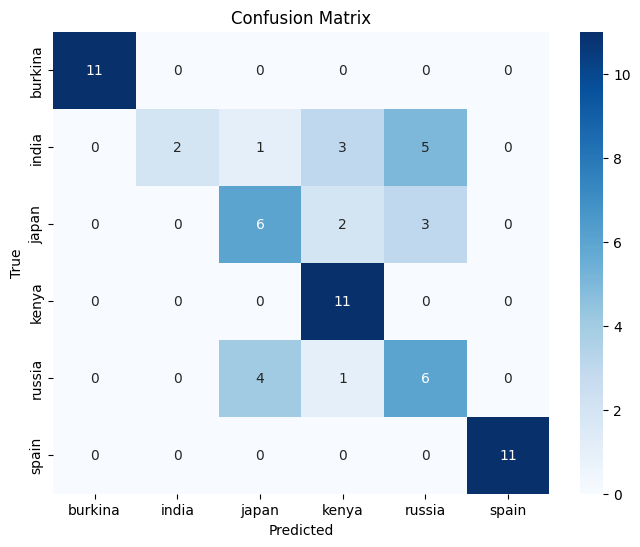

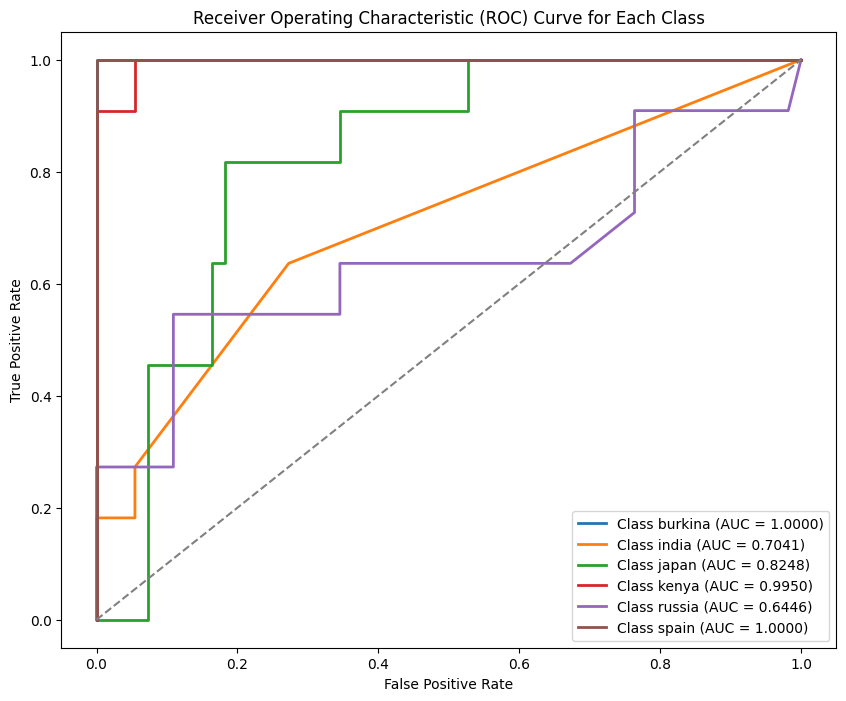

In [17]:
# Step 1: Load the saved files
rf_model = joblib.load('random_forest_model.joblib')
kmer_vectorizer = joblib.load('kmer_vectorizer.joblib')
scaler_kmer = joblib.load('scaler_kmer.joblib')
label_encoder = joblib.load('label_encoder.joblib')

# Step 2: Load the new validation data
df_validation = pd.read_csv('hvr1_hvr2_cleaned_sequences_validation.csv')

# Step 3: Preprocess the new data
# Apply regex to remove digits from the geo_loc column (same as in training)
df_validation['geo_loc'] = df_validation['geo_loc'].apply(lambda x: re.sub(r'\d+', '', x))

# We only need the 'HVR1' column from the validation dataset
X_validation = df_validation['HVR1']

# Step 4: Apply K-mer transformation to the validation data
X_validation_kmer = kmer_vectorizer.transform(X_validation)

# Step 5: Feature scaling (same scaling as for the training data)
X_validation_kmer_scaled = scaler_kmer.transform(X_validation_kmer)

# Step 6: Encode the target (geo_loc) using the same label_encoder
y_validation_encoded = label_encoder.transform(df_validation['geo_loc'])

# Step 7: Make predictions using the trained model
y_pred_encoded = rf_model.predict(X_validation_kmer_scaled)

# Step 8: Decode the predicted labels back to original classes
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Step 9: Decode the true labels (geo_loc) to string format as well
y_validation = label_encoder.inverse_transform(y_validation_encoded)

# Step 10: Calculate test accuracy
test_accuracy = accuracy_score(y_validation, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Step 11: Display results
# Print the classification report
print("\nClassification Report:")
# Now, both true and predicted labels are strings
print(classification_report(y_validation, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_validation, y_pred)

# Plot Confusion Matrix (in blue color)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve for each class
plt.figure(figsize=(10, 8))

# Predict probabilities for each class
y_pred_proba = rf_model.predict_proba(X_validation_kmer_scaled)

# Compute ROC curve and AUC for each class
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_validation_encoded, y_pred_proba[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_name} (AUC = {roc_auc:.4f})')

# Plot the ROC curve
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc='lower right')
plt.show()


# 7. Loading and checking model

In [18]:
class GeoLocationPredictor:
    def __init__(self,
                 label_encoder_path='label_encoder.joblib',
                 vectorizer_path='kmer_vectorizer.joblib',
                 scaler_path='scaler_kmer.joblib',
                 classifier_path='random_forest_model.joblib'):
        """
        Initialize the predictor by loading saved model components.

        Parameters:
        -----------
        label_encoder_path : str
            Path to saved label encoder
        vectorizer_path : str
            Path to saved k-mer vectorizer
        scaler_path : str
            Path to saved feature scaler
        classifier_path : str
            Path to saved random forest classifier
        """
        # Load saved model components
        self.label_encoder = joblib.load(label_encoder_path)
        self.vectorizer = joblib.load(vectorizer_path)
        self.scaler = joblib.load(scaler_path)
        self.classifier = joblib.load(classifier_path)

    def predict(self, sequences):
        """
        Predict geo_location for given HVR1 sequences.

        Parameters:
        -----------
        sequences : list or str
            Input sequence(s) to predict

        Returns:
        --------
        list
            Predicted geo_location labels
        """
        # Ensure sequences is a list
        if isinstance(sequences, str):
            sequences = [sequences]

        # Convert sequences to strings
        sequences = [str(seq) for seq in sequences]

        # Apply K-mer transformation
        X_kmer = self.vectorizer.transform(sequences)

        # Scale features
        X_scaled = self.scaler.transform(X_kmer)

        # Predict
        y_pred_encoded = self.classifier.predict(X_scaled)

        # Decode predictions to geo-location labels
        return [self.label_encoder.inverse_transform([pred])[0] for pred in y_pred_encoded]

    def predict_proba(self, sequences):
        """
        Predict geo_location probabilities for given HVR1 sequences.

        Parameters:
        -----------
        sequences : list or str
            Input sequence(s) to predict

        Returns:
        --------
        list of dicts
            Probability predictions for each class
        """
        # Ensure sequences is a list
        if isinstance(sequences, str):
            sequences = [sequences]

        # Convert sequences to strings
        sequences = [str(seq) for seq in sequences]

        # Apply K-mer transformation
        X_kmer = self.vectorizer.transform(sequences)

        # Scale features
        X_scaled = self.scaler.transform(X_kmer)

        # Predict probabilities
        y_pred_proba = self.classifier.predict_proba(X_scaled)

        # Convert to list of dicts with class names as keys
        return [
            dict(zip(self.label_encoder.classes_, proba))
            for proba in y_pred_proba
        ]

def predict_geo_location(hvr1_sequence):
    """
    Predict geo_location based on HVR1 sequence.

    Parameters:
    -----------
    hvr1_sequence : str
        HVR1 DNA sequence

    Returns:
    --------
    str
        Predicted geo_location
    """
    # Initialize predictor
    predictor = GeoLocationPredictor()

    # Predict geo_location
    predictions = predictor.predict(hvr1_sequence)

    # Return the first (and likely only) prediction
    return predictions[0]

# Example usage
def main():
    # Get input from user
    hvr1_input = input("Enter HVR1 sequence: ")

    try:
        # Predict geo_location
        geo_location = predict_geo_location(hvr1_input)
        print(f"Predicted Geo Location: {geo_location}")

        # Optional: Get probabilities
        predictor = GeoLocationPredictor()
        probabilities = predictor.predict_proba(hvr1_input)
        print("\nDetailed Probabilities:")
        for geo_loc, probability in sorted(probabilities[0].items(), key=lambda x: x[1], reverse=True):
            print(f"{geo_loc}: {probability:.2%}")

    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()


Enter HVR1 sequence: NNNNNCTTTCATGGGGAAACAGATTTGGGTACCACCCAAGTATTGACTCACCCATCAACAACCGCTATGTATTTCGTACATTACTGCCAGCCACCATGAATATTGTACGGTACCATAAATACTTGACCACCTGTAGTACATAAAAACCCAATCCACATCAAANACCCCCCCCCCATGCTTACNNAAGCAAGTACAGCAATCAACCTTCAACTATCACACATCAACTGCAANNNNNNNNCTCCAAAGCCACCCCTCACCCANCTAGGATACCAACAAACCTATCCACCCTTAACAGTACATAGTACATAAANNNNNNNNNNNNACCATTTACCGTACATAGCACATTACAGTCAAATCCCCTCTCGCCCCCNNNNNNNNNNNNN
Predicted Geo Location: russia

Detailed Probabilities:
russia: 62.04%
japan: 20.96%
kenya: 8.00%
burkina: 4.00%
spain: 4.00%
india: 1.00%
